# LESS is More

We are now ready to dig deep into LESS. Consider a set of feature-response pairs $(\mathbf{x}_i, y_i)$, $i=1, \dots, n$. To simplify our notation, we denote this dataset by $(\mathbf{X}, \mathbf{y})$. 

The following figure shows what lies under the hood of LESS. The algorithm starts with creating (random) **subsets** $(\mathbf{X}_j, \mathbf{y}_j) \subseteq (\mathbf{X}, \mathbf{y})$, and for each subset $j$, the algorithm learns a **local estimator** $\mathcal{L}(\mathbf{x} | \mathbf{X}_j, \mathbf{y}_j)$. As we only use different subsets for training, we expect that these predictions are more reliable when a test sample is __close__ to subset $\mathbf{X}_j$. Thus, we also define a **distance function** $\phi(\mathbf{x}, \mathbf{X}_j)$ that plays the role of weighting, and it returns a value that is inversely proportional to the distance between a sample and a subset. The local predictions are then combined to yield an overall **global estimator** $\mathcal{G}(\mathbf{x} | \mathbf{Z}, \mathbf{y})$. Here, $\mathbf{Z}$ is the $n \times m$ matrix, whose rows are formed by the vectors
$$
  \mathbf{z}_i = \left[\phi(\mathbf{x}_i, \mathbf{X}_j) \mathcal{L}(\mathbf{x}_i |\mathbf{X}_j, \mathbf{y}_j)\right]_{j=1}^m, \ \ i=1, \dots, n.
$$

<img src="img/LESS1Level.png"  width=589 height=334/>

In summary, LESS consists of the following **three parts**:

1. Selecting subsets
2. Setting local and global estimators
3. Defining a distance function

Next, we will discuss how changing any one of these parts (or removing some) leads to a new model. This makes LESS a very flexible learning algorithm.

## Part 1: Selecting Subsets

There are two main ways of selecting the subsets in LESS: random subset generation and clustering.

**Random Subsets**

The first, and the default, way is to randomly select a fraction of the samples to construct each subset. This also automatically determines the number of subsets. This fraction can be set by the parameter `frac`, which has the default value of 0.05.

In [1]:
import numpy as np
import datasets as DS
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from less import LESSRegressor

df = np.array(DS.abalone('./datasets/'))
X, y = df[:, 0:-1], df[:, -1]

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3)

print('Total number of training samples: {0}\n'.format(len(X_train)))
print('Default frac (5% of samples in each subset)')
LESS_model = LESSRegressor()
y_pred = LESS_model.fit(X_train, y_train).predict(X_test)
print('Number of subsets:', LESS_model.get_n_subsets())
print('Number of samples in each subset: ', LESS_model.get_n_neighbors())
print('Test error of LESS: {0:.2f}\n'.format(mean_squared_error(y_pred, y_test)))
print('frac=0.01  - (1% of samples in each subset)')
LESS_model = LESSRegressor(frac=0.01)
y_pred = LESS_model.fit(X_train, y_train).predict(X_test)
print('Number of subsets:', LESS_model.get_n_subsets())
print('Number of samples in each subset: ', LESS_model.get_n_neighbors())
print('Test error of LESS: {0:.2f}'.format(mean_squared_error(y_pred, y_test)))

Total number of training samples: 2923

Default frac (5% of samples in each subset)
Number of subsets: 19
Number of samples in each subset:  153
Test error of LESS: 4.37

frac=0.01  - (1% of samples in each subset)
Number of subsets: 97
Number of samples in each subset:  30
Test error of LESS: 4.24


LESS, first selects some anchors, and then creates the subsets with the neighboring samples to these anchors. Thus, the number of anchors is equal to the number of subsets. In its current version of LESS, the distance between the anchors and the neighboring solutions are evaluated as Euclidean distance ($\ell_2$-norm).

You can also set either the number of subsets (`n_subsets`), or the number of samples in each subset (`n_neighbors`), or even both. Please note that if you also set the parameter `frac`, then your input for `n_subsets` and `n_neighbors` are ignored.

In [2]:
LESS_model = LESSRegressor(n_subsets=10)
y_pred = LESS_model.fit(X_train, y_train).predict(X_test)
print('Number of subsets:', LESS_model.get_n_subsets())
print('Number of samples in each subset: ', LESS_model.get_n_neighbors())
print('Test error of LESS: {0:.2f}\n'.format(mean_squared_error(y_pred, y_test)))

LESS_model = LESSRegressor(n_neighbors=50)
y_pred = LESS_model.fit(X_train, y_train).predict(X_test)
print('Number of subsets:', LESS_model.get_n_subsets())
print('Number of samples in each subset: ', LESS_model.get_n_neighbors())
print('Test error of LESS: {0:.2f}\n'.format(mean_squared_error(y_pred, y_test)))

LESS_model = LESSRegressor(n_subsets=10, n_neighbors=50)
y_pred = LESS_model.fit(X_train, y_train).predict(X_test)
print('Number of subsets:', LESS_model.get_n_subsets())
print('Number of samples in each subset: ', LESS_model.get_n_neighbors())
print('Test error of LESS: {0:.2f}\n'.format(mean_squared_error(y_pred, y_test)))

LESS_model = LESSRegressor(frac=0.01, n_subsets=10, n_neighbors=50) # only parameter 'frac' is used
y_pred = LESS_model.fit(X_train, y_train).predict(X_test)
print('Number of subsets:', LESS_model.get_n_subsets())
print('Number of samples in each subset: ', LESS_model.get_n_neighbors())
print('Test error of LESS: {0:.2f}'.format(mean_squared_error(y_pred, y_test)))

Number of subsets: 10
Number of samples in each subset:  292
Test error of LESS: 4.51

Number of subsets: 58
Number of samples in each subset:  50
Test error of LESS: 4.22

Number of subsets: 10
Number of samples in each subset:  50
Test error of LESS: 4.51

Number of subsets: 97
Number of samples in each subset:  30
Test error of LESS: 4.22


Since the local subsets are created randomly, LESS is run for a fixed number of replication and the average over these replications is reported. This replication step decreases the variance. The corresponding parameter is called `n_replications`, and it is set to 20 as default. 

In fact, there is an interesting take here about the bias-variance trade-off. Going back to our one-dimensional synthetic example from the first part of the tutorial, we can demonstrate the effects of this trade-off.

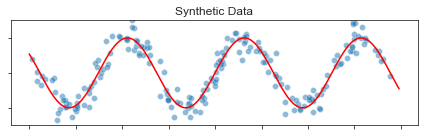

In [3]:
import lesstutorial as lt
X, y = lt.synthetic_sine_curve(n_samples=200)

Recall that the blue dots in the figure show our dataset.

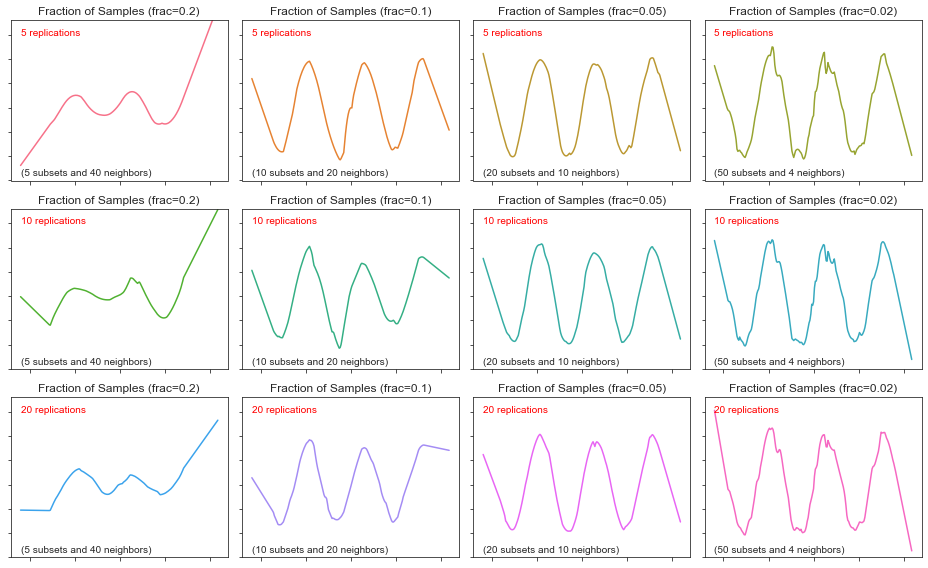

In [4]:
lt.less_bias_vs_variance(X, y)

This panel of figures show that as the number of subsets becomes too large, LESS may start to overfit to the training data (less bias). However, this may also cause an increase in variance. Hence, the trade-off.

**Clustering**

The second way for subset selection is using a clustering method with the parameter `cluster_method`. LESS works with several [`scikit-learn` clustering methods](https://scikit-learn.org/stable/modules/clustering.html). Here is an example with [K-means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans).

In [5]:
from sklearn.cluster import KMeans
LESS_model = LESSRegressor(cluster_method=KMeans)
y_pred = LESS_model.fit(X_train, y_train).predict(X_test)
print('Test error of LESS: {0:.2f}'.format(mean_squared_error(y_pred, y_test)))

Test error of LESS: 4.59


You can also set the parameters of the clustering method by defining a `lambda` function.

In [6]:
cl_method = lambda: KMeans(n_clusters=20, n_init=30)

LESS_model = LESSRegressor(cluster_method=cl_method)
y_pred = LESS_model.fit(X_train, y_train).predict(X_test)
print('Test error of LESS: {0:.2f}'.format(mean_squared_error(y_pred, y_test)))

Test error of LESS: 4.38


## Part 2: Setting Local and Global Estimators

LESS uses [linear regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) as its default local and global estimators. However, you are free to use most of the `scikit-learn` regressors, as long as they provide the usual `fit()` and `predict()` functions. Here, the corresponding parameters are `local_estimator` and `global_estimator`. By the help of `lambda` functions, you can also change the parameters used with these regressors. 

In the following examples, we use gradient boosting for the global estimator, and decision trees for the the local estimators.

In [7]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

LESS_model = LESSRegressor(local_estimator=DecisionTreeRegressor, 
                           global_estimator=GradientBoostingRegressor)
y_pred = LESS_model.fit(X_train, y_train).predict(X_test)
print('Test error of LESS: {0:.2f}'.format(mean_squared_error(y_pred, y_test)))

loc_est = lambda: DecisionTreeRegressor(max_depth=3)
glob_est = lambda: GradientBoostingRegressor(learning_rate=0.05)

LESS_model = LESSRegressor(local_estimator=loc_est, 
                           global_estimator=glob_est)
y_pred = LESS_model.fit(X_train, y_train).predict(X_test)
print('Test error of LESS: {0:.2f}'.format(mean_squared_error(y_pred, y_test)))

Test error of LESS: 4.66
Test error of LESS: 4.80


You can also try different estimators with clustering. One can even remove the global estimator (`global_estimator=None`) and obtain a prediction as the weighted average of the local estimators. It is important to note that removing a local estimator by setting it to `None` is not allowed.

In [8]:
from sklearn.cluster import SpectralClustering

cl_method = lambda: SpectralClustering(n_clusters=10)

LESS_model = LESSRegressor(cluster_method=cl_method, 
                           global_estimator=glob_est)
y_pred = LESS_model.fit(X_train, y_train).predict(X_test)
print('Test error of LESS: {0:.2f}'.format(mean_squared_error(y_pred, y_test)))

LESS_model = LESSRegressor(cluster_method=cl_method, 
                           global_estimator=None)
y_pred = LESS_model.fit(X_train, y_train).predict(X_test)
print('Test error of LESS: {0:.2f}'.format(mean_squared_error(y_pred, y_test)))

Test error of LESS: 4.28
Test error of LESS: 63.20


For this example, the prediction is really off without the global estimator.

## Part 3: Defining a Distance Function

The last part of LESS relies on selecting the distance of each sample to a given subset. As default, LESS uses
$$
  \phi(\mathbf{x}_i, \mathbf{X}_j) = \exp\left(-\tfrac{1}{m^2}\|\mathbf{x}_i - \bar{\mathbf{x}}_j\|\right),
$$
where $m$ is the number of subsets (`n_subsets`) and $\bar{\mathbf{x}}_j$ is the centroid of the samples in subset $\mathbf{X}_j$. These distances play the role of weighting each local estimator's prediction. Then, all these distances are normalized so that they will add up to one. If you do not want to normalize these weights, then you can set the parameter `d_normalize` to `False`. However, if `global_estimator=None`, then LESS sets `d_normalize` to `True` automatically.

Like all other parts of LESS, users are free to change the distance function. The only requirement is that the distance function should take two `numpy` arrays as input, and returns a `numpy` array of distances as output. Below, we give an example function similar to Laplacian kernel.

In [9]:
def laplacian(data, center, coeff=1.0):
    
    return np.exp(-coeff * np.linalg.norm(np.array(data - center, dtype=float), ord=1, axis=1))

 When the distance function requires more parameters, this can be achieved again by defining a `lambda` function. 

In [10]:
LESS_model = LESSRegressor(distance_function=laplacian)
y_pred = LESS_model.fit(X_train, y_train).predict(X_test)
print('Test error of LESS: {0:.2f}'.format(mean_squared_error(y_pred, y_test)))

dist_fnc = lambda data, center: laplacian(data, center, coeff=0.5)

LESS_model = LESSRegressor(distance_function=dist_fnc)
y_pred = LESS_model.fit(X_train, y_train).predict(X_test)
print('Test error of LESS: {0:.2f}'.format(mean_squared_error(y_pred, y_test)))

Test error of LESS: 4.39
Test error of LESS: 4.40


With a bit of effort, you can also use the kernel functions from [`sklearn.metrics`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics).

In [11]:
from sklearn.metrics.pairwise import rbf_kernel

def dist_RBFKernel(data, center, coeff=1.0):

    return np.diag(rbf_kernel(data, np.tile(center, (len(data), 1)), gamma=coeff))

dist_fnc = lambda data, center: dist_RBFKernel(data, center, coeff=0.01)

LESS_model = LESSRegressor(distance_function=dist_fnc)
y_pred = LESS_model.fit(X_train, y_train).predict(X_test)
print('Test error of LESS: {0:.2f}'.format(mean_squared_error(y_pred, y_test)))

Test error of LESS: 4.32


We should point out that if you use a clustering method and the method also provides the cluster centers, then LESS uses the cluster centers instead of the centroids of the samples in the subsets.

## Other Parameters

We conclude the tutorial with the remaining three parameters `random_state`, `val_size`, and `tree_method`. 

If you set `random_state` to an integer value, LESS will use the same random seed for all random elements. This guarantees to obtain the same result with each call. 

In [12]:
fix_seed_results = []
for i in range(5):
    LESS_model = LESSRegressor(random_state=2021)
    y_pred = LESS_model.fit(X_train, y_train).predict(X_test)
    fix_seed_results.append(round(mean_squared_error(y_pred, y_test), 2))
    
non_fix_seed_results = []
for i in range(5):
    LESS_model = LESSRegressor()
    y_pred = LESS_model.fit(X_train, y_train).predict(X_test)
    non_fix_seed_results.append(round(mean_squared_error(y_pred, y_test), 2))

print('Fixed seed results: {0}'.format(fix_seed_results))
print('Non fixed seed results: {0}'.format(non_fix_seed_results))

Fixed seed results: [4.38, 4.38, 4.38, 4.38, 4.38]
Non fixed seed results: [4.38, 4.38, 4.37, 4.38, 4.39]


Default LESS uses the entire dataset for creating the subsets and for fitting the estimators. An option is to further split the dataset into training and validation sets. Then, training set is used for the local estimators and the validation set is used for the global estimator. This option can be enabled by setting the parameter `val_size` to a value from the interval $(0 , 1)$. This value shows the fraction of the dataset that will be reserved for the validation.

In [13]:
LESS_model = LESSRegressor(random_state=2021, val_size=0.5)
y_pred = LESS_model.fit(X_train, y_train).predict(X_test)
print('Test error of LESS: {0:.2f}'.format(mean_squared_error(y_pred, y_test)))

Test error of LESS: 4.34


The very last optional parameter `tree_method` specifies the algorithm used for searching the closest neighbors to each anchor. By default, LESS uses [`KDTree`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html). This method can also be replaced by another function, which should take a `numpy` array (representing the data) and the number of neighbors as input parameters. The output is expected to be a tree for querying the nearest neighbors. Here is an example function using [`BallTree`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html#sklearn.neighbors.BallTree) from `scikit-learn`.

In [14]:
from sklearn.neighbors import BallTree

tr_method = lambda data, leaf_size: BallTree(data, leaf_size, metric='chebyshev')

LESS_model = LESSRegressor(random_state=2021, val_size=0.5, tree_method=tr_method)
y_pred = LESS_model.fit(X_train, y_train).predict(X_test)
print('Test error of LESS: {0:.2f}'.format(mean_squared_error(y_pred, y_test)))

Test error of LESS: 4.35


## Next Steps

We hope that this tutorial shows the flexible structure of LESS. There are many ideas that one can consider in the future. Here is a quick list with only a few of them: 

- Using different local estimators for different subsets
- Using LESS itself as a local or global estimator (LESSception)
- Parallel implementation for huge datasets
- Implementation for an online learning setting
- ...